In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
df = pd.read_csv("emails.csv")

In [13]:
df.shape

(5728, 2)

In [14]:
df.groupby("spam").describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [15]:
X, y = df["text"], df["spam"]
X, y = X.to_frame(), y.to_frame()

In [16]:
X

,text
0,Subject: naturally irresistible your corporate...
1,Subject: the stock trading gunslinger fanny i...
2,Subject: unbelievable new homes made easy im ...
3,Subject: 4 color printing special request add...
4,"Subject: do not have money , get software cds ..."
...,...
5723,Subject: re : research and development charges...
5724,"Subject: re : receipts from visit jim , than..."
5725,Subject: re : enron case study update wow ! a...
5726,"Subject: re : interest david , please , call..."


In [17]:
y

,spam
0,1
1,1
2,1
3,1
4,1
...,...
5723,0
5724,0
5725,0
5726,0


In [18]:
import nltk
import re

def text_preprocess(sentence):
    # Tokenization
    tokens = nltk.word_tokenize(sentence)

    # Symbol Removal
    n_corpus = []
    for i in range(len(tokens)):
        review = re.sub(r"[^a-zA-Z]", " ", tokens[i])
        review = review.lower()
        n_corpus.append(review)

    # Stopword Removal
    stopwords = nltk.corpus.stopwords.words("english")
    rem_stopwords = [words for words in n_corpus if words not in stopwords and 
                     len(words.split()) != 0 and 
                     len(words) > 2]

    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    transformed_words = [lemmatizer.lemmatize(words) for words in rem_stopwords]

    return " ".join(transformed_words)

In [19]:
with tf.device("CPU"):
    X["new_text"] = X["text"].apply(text_preprocess)

In [20]:
X.head()

,text,new_text
0,Subject: naturally irresistible your corporate...,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,subject unbelievable new home made easy wantin...
3,Subject: 4 color printing special request add...,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",subject money get software cd software compati...


In [21]:
y["spam"]

0       1
1       1
2       1
3       1
4       1
       ..
5723    0
5724    0
5725    0
5726    0
5727    0
Name: spam, Length: 5728, dtype: int64

Visualizing spam words

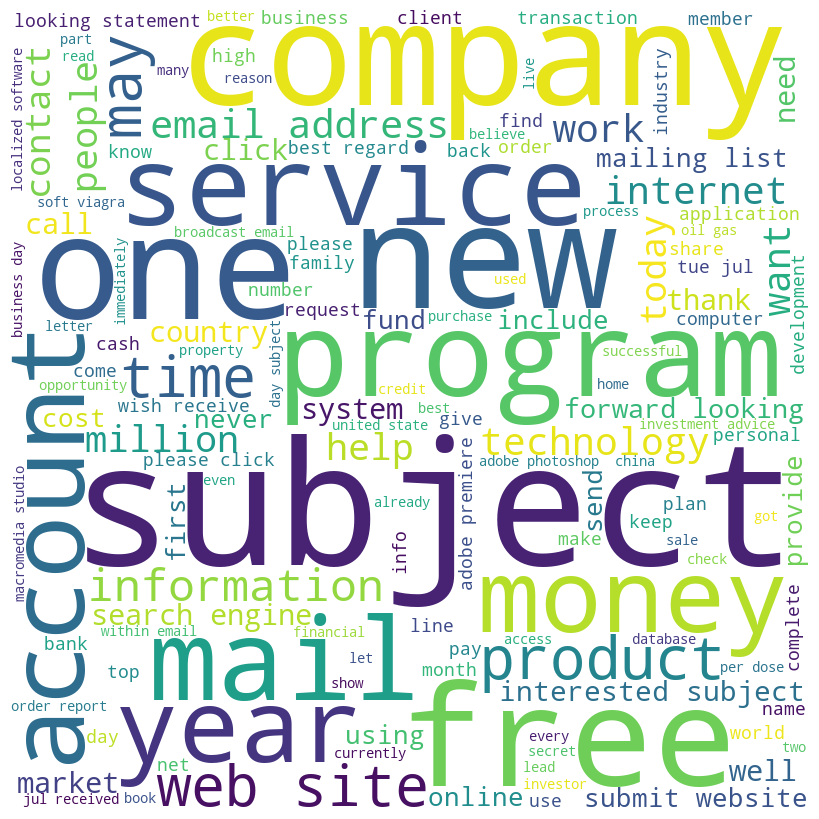

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 1])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Visualizing ham words

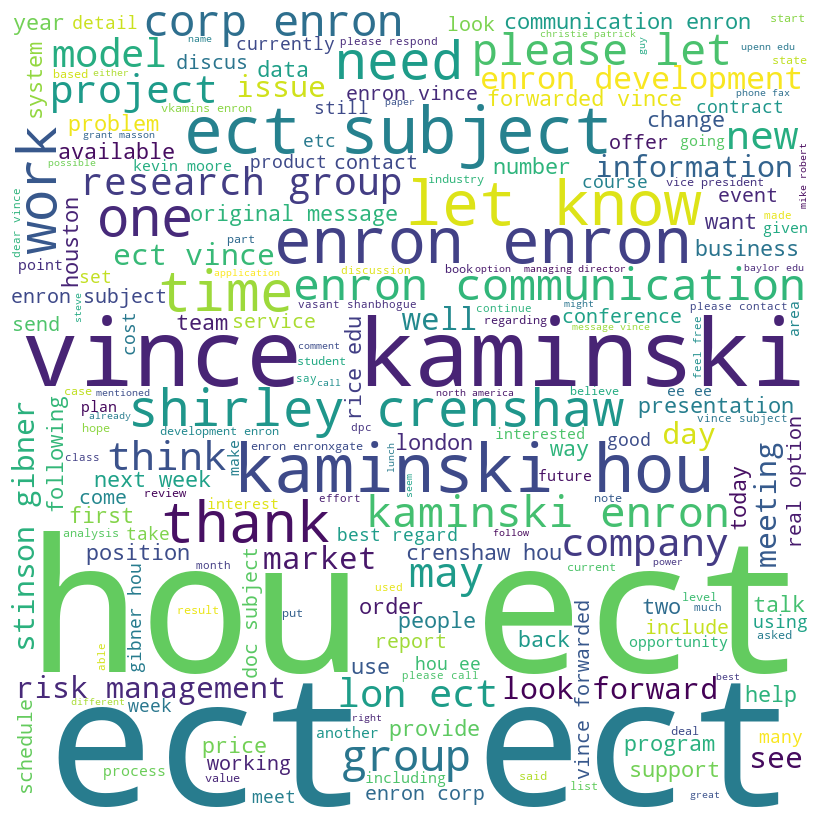

In [43]:
comment_words = " ".join([X._get_value(i, "new_text") for i in range(len(y)) 
                          if y._get_value(i, "spam") == 0])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

One hot Encoding

In [23]:
from tensorflow.keras.preprocessing.text import one_hot

In [24]:
vocab_size = 5000

In [25]:
encoded_words = [one_hot(words, vocab_size) for words in X["new_text"]]
encoded_words

[[1866,
  2358,
  4743,
  3960,
  4942,
  207,
  320,
  1547,
  2043,
  1748,
  869,
  2227,
  1538,
  4607,
  329,
  2301,
  4015,
  2198,
  4469,
  783,
  3940,
  1586,
  4894,
  1909,
  2560,
  2366,
  942,
  1775,
  2053,
  2043,
  154,
  3520,
  1229,
  3660,
  429,
  4078,
  3538,
  329,
  3629,
  3035,
  656,
  333,
  650,
  1914,
  838,
  4001,
  1748,
  2366,
  3832,
  4251,
  3520,
  1909,
  3035,
  341,
  3976,
  2857,
  2753,
  4286,
  188,
  4881,
  4015,
  4717,
  439,
  1934,
  1157,
  2043,
  2092,
  32,
  4015,
  2769,
  3172,
  2301,
  1491,
  276,
  2784,
  2732,
  4217,
  3080,
  3738,
  3940,
  2784,
  64,
  4332,
  4514,
  3936,
  4015,
  1667,
  4939,
  4918,
  656,
  661,
  1607,
  3832,
  1979,
  1586,
  4224,
  4071,
  390,
  1763,
  1969,
  825,
  4885,
  3738,
  1157,
  3122,
  1489,
  3044,
  3502,
  1630,
  4590,
  3541,
  234],
 [1866,
  3426,
  1937,
  4999,
  3535,
  2506,
  3036,
  1805,
  197,
  2096,
  3162,
  1680,
  441,
  724,
  2166,
  1535,
  43

Word Embedding

In [26]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [27]:
max_length = len(max(X["new_text"]))

In [36]:
embedded_words = pad_sequences(encoded_words, padding="pre", maxlen=max_length)
print(embedded_words)

[[   0    0    0 ... 4590 3541  234]
 [   0    0    0 ...  882  416  964]
 [   0    0    0 ... 4118  162 1484]
 ...
 [   0    0    0 ... 4216 1178 1220]
 [   0    0    0 ... 1164 4403 2531]
 [   0    0    0 ... 1538 2252 2086]]


Model

In [29]:
feature_dim = 50

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(vocab_size, feature_dim ,input_length=max_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 581, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 581, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________


In [38]:
X_final, y_final = np.array(embedded_words), np.array(y)

In [39]:
X_final.shape

(5728, 581)

In [40]:
y_final.shape

(5728, 1)

Splitting into Training and Testing

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10


68/68 [==============================] - 9s 80ms/step - loss: 0.3914 - accuracy: 0.8359 - val_loss: 0.1033 - val_accuracy: 0.9728
Epoch 2/10
68/68 [==============================] - 5s 77ms/step - loss: 0.0871 - accuracy: 0.9742 - val_loss: 0.0872 - val_accuracy: 0.9686
Epoch 3/10
68/68 [==============================] - 5s 75ms/step - loss: 0.0308 - accuracy: 0.9923 - val_loss: 0.0750 - val_accuracy: 0.9714
Epoch 4/10
68/68 [==============================] - 5s 70ms/step - loss: 0.0155 - accuracy: 0.9965 - val_loss: 0.0727 - val_accuracy: 0.9756
Epoch 5/10
68/68 [==============================] - 5s 70ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.0725 - val_accuracy: 0.9763
Epoch 6/10
68/68 [==============================] - 5s 79ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.0863 - val_accuracy: 0.9749
Epoch 7/10
68/68 [==============================] - 6s 85ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1102 - val_accuracy: 0.9728
Epoch 8/10
68/68 [======

In [42]:
y_pred = model.predict(X_test)
y_pred

array([[0.5021324 ],
       [0.5005428 ],
       [0.4991304 ],
       ...,
       [0.50190884],
       [0.49956658],
       [0.50313306]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1061,    2],
       [  41,  328]], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9699720670391061

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1063
           1       0.99      0.89      0.94       369

    accuracy                           0.97      1432
   macro avg       0.98      0.94      0.96      1432
weighted avg       0.97      0.97      0.97      1432

